# ***DCT WATERMARKING***

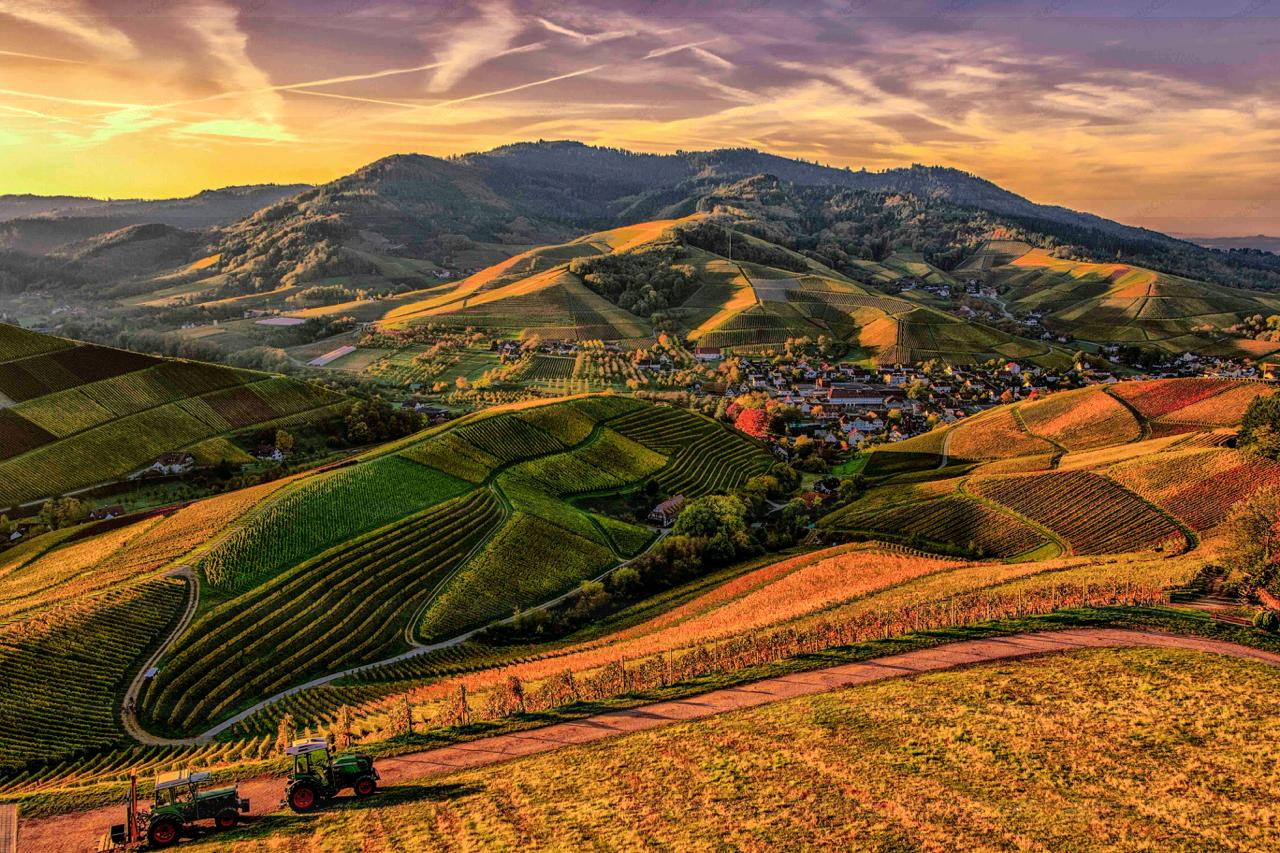

Watermarked color image saved as watermarked_color.jpg


In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def prepare_tiled_watermark(host_shape, watermark_path, opacity=0.05, scale=0.2, angle=30, spacing=100):
    wm = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)
    if wm is None:
        raise FileNotFoundError(f"Watermark image not found at {watermark_path}")

    wm_small = cv2.resize(wm, (int(wm.shape[1]*scale), int(wm.shape[0]*scale)))
    center = (wm_small.shape[1]//2, wm_small.shape[0]//2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    wm_rotated = cv2.warpAffine(wm_small, rot_matrix, (wm_small.shape[1], wm_small.shape[0]), borderValue=255)

    tiled_wm = np.zeros(host_shape, dtype=np.float32)
    for y in range(0, host_shape[0], spacing):
        for x in range(0, host_shape[1], spacing):
            y1, y2 = y, min(y + wm_rotated.shape[0], host_shape[0])
            x1, x2 = x, min(x + wm_rotated.shape[1], host_shape[1])
            wm_crop = wm_rotated[0:(y2-y1), 0:(x2-x1)]
            tiled_wm[y1:y2, x1:x2] = np.maximum(tiled_wm[y1:y2, x1:x2], wm_crop)

    tiled_wm = (tiled_wm / 255.0) * 255.0 * opacity
    return tiled_wm

def dct_watermarking_color(host_path, watermark_path, opacity=0.05, output_path="watermarked_color.jpg"):
    host = cv2.imread(host_path)
    if host is None:
        raise FileNotFoundError(f"Host image not found at {host_path}")

    watermarked = np.zeros_like(host, dtype=np.uint8)

    # Apply watermark to each channel
    for c in range(3):
        channel = host[:, :, c].astype(np.float32)
        tiled_wm = prepare_tiled_watermark(channel.shape, watermark_path, opacity=opacity)

        channel_dct = cv2.dct(channel)
        wm_dct = cv2.dct(tiled_wm)

        watermarked_dct = channel_dct + wm_dct
        watermarked[:, :, c] = np.clip(cv2.idct(watermarked_dct), 0, 255).astype(np.uint8)
    cv2.imwrite(output_path, watermarked)
    return watermarked

host_img = "cover2.jpg"
wm_img = "logo.png"
result = dct_watermarking_color(host_img, wm_img, opacity=0.03, output_path="watermarked_color.jpg")
cv2_imshow(result)
print("Watermarked color image saved as watermarked_color.jpg")


# ***DCT WATERMARK DETECTION***

In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_watermark_color(watermarked_path, watermark_path, threshold=0.05):
    watermarked = cv2.imread(watermarked_path)
    watermark = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)

    if watermarked is None or watermark is None:
        raise FileNotFoundError("Images not found.")

    # Resize watermark to match host image
    wm_resized = cv2.resize(watermark, (watermarked.shape[1], watermarked.shape[0]))

    correlations = []

    for c in range(3):  # R, G, B channels
        channel = watermarked[:, :, c].astype(np.float32)
        channel_dct = cv2.dct(channel)
        wm_dct = cv2.dct(np.float32(wm_resized))

        # Normalized correlation
        corr = np.sum(channel_dct * wm_dct) / (np.linalg.norm(channel_dct) * np.linalg.norm(wm_dct))
        correlations.append(corr)

    avg_corr = np.mean(correlations)
    print(f"Average correlation: {avg_corr:.4f}")

    if avg_corr > threshold:
        print("Watermark detected!")
    else:
        print("Watermark not detected!")

watermarked_img = "watermarked_color.jpg"
wm_img = "logo.png"
detect_watermark_color(watermarked_img, wm_img, threshold=0.05)


Average correlation: 0.8007
Watermark detected!
